# Simulated Maximum Likelihood

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.special import ndtri
from scipy.stats import norm, lognorm

from scipy.optimize import minimize
import pickle


In [2]:
fname = 'results_raw.pickle'
# Create a writer object
file = open(fname, 'rb')

# dump information
results_decision = pickle.load(file)

# close file
file.close()

fname = 'results_raw_50.pickle'
# Create a writer object
file = open(fname, 'rb')

# dump information
results_decision_50 = pickle.load(file)

# close file
file.close()

fname = 'results_raw_25.pickle'
# Create a writer object
file = open(fname, 'rb')

# dump information
results_decision_25 = pickle.load(file)

# close file
file.close()

In [3]:
# Combine all subject DataFrames into one, with subject as an index level
df_25 = pd.concat(results_decision_25, names=['subject'])
df_25


trial_num  response_time  invest  prob_win  prob_loss  prob_ambi  \
subject                                                                        
11112   50         51      10.135179     0.0       0.3        0.0        0.7   
        51         52       2.689500     0.0       0.1        0.2        0.7   
        52         53       2.324491     0.0       0.1        0.2        0.7   
        53         54       1.973378     0.0       0.4        0.1        0.5   
        54         55       1.451457     0.0       0.2        0.0        0.8   
...               ...            ...     ...       ...        ...        ...   
9031985 70         71       6.411496     1.0       0.1        0.3        0.6   
        71         72       2.670053     1.0       0.0        0.1        0.9   
        72         73       5.120200     0.0       0.7        0.0        0.3   
        73         74       8.394112     1.0       0.1        0.2        0.7   
        74         75       3.433346     1.0       0.4        0.5        0.1   

               gain    loss  lottery_trial_num  group_responsibility  
subject                                                               
11112   50   8000.0 -5000.0               74.0                   1.0  
        51   6000.0 -4000.0               52.0                   1.0  
        52   7000.0 -2000.0               67.0                   1.0  
        53   7000.0 -5000.0               72.0                   1.0  
        54  10000.0 -6000.0               69.0                   1.0  
...             ...     ...                ...                   ...  
9031985 70   5000.0 -2000.0               59.0                   1.0  
        71   7000.0 -3000.0               58.0                   1.0  
        72   3000.0 -7000.0               71.0                   1.0  
        73   6000.0 -4000.0               52.0                   1.0  
        74  10000.0 -3000.0               73.0                   1.0  

[925 rows x 10 columns]

We need to estimate the following likelihood function weighted by the "parameter" plausibility. First Step:

\begin{align*}
L(x,w) &= \Pi_{s=1}^{S}\int\int\int\int\left[\Pi_{i=1}^{N}c(y_{s,i}|\lambda,\alpha,\gamma,\theta)\right] %
\cdot LN(\lambda|\mu_\lambda,\sigma_\lambda) \cdot LN(\alpha|\mu_\alpha,\sigma_\alpha) %
\cdot LN(\theta|\mu_\theta,\sigma_\theta) \cdot LN(\gamma|\mu_\gamma,\sigma_\gamma) % 
d\theta d\gamma d\lambda d\alpha,\\
Log L(x,w) &= \sum_{s=1}^{S}\ln\left(\int\int\int\int\left[\Pi_{i=1}^{N}c(y_{s,i}|\lambda,\alpha,\gamma,\theta)\right] %
\cdot LN(\lambda|\mu_\lambda,\sigma_\lambda) \cdot LN(\alpha|\mu_\alpha,\sigma_\alpha) %
\cdot LN(\theta|\mu_\theta,\sigma_\theta) \cdot LN(\gamma|\mu_\gamma,\sigma_\gamma) % 
d\theta d\gamma d\lambda d\alpha\right)
\end{align*}
where S is number of Subjects and N is number of trials/rounds

We approximate the intergral by Haltond draws and find the best $\mu$ and $\sigma$ estimate for each parameter and its LogNormal distribution in the population.
Once we have the Halton Draws:

Simulate the integral as:
\begin{align*}
\frac1R \sum_{r_\gamma}^R \left[ \Pi_i^N \frac{1}{1 + exp{(-\tau\cdot (2\cdot 1_{y=1}-1) \cdot u(x,\theta_{r_\theta},\alpha_{r_\alpha},\lambda_{r_\lambda},\gamma_{r_\gamma}))}}\right]
\end{align*}

\begin{align*}
u()&=x_g^\alpha \cdot \pi(\tilde p_g) + (-\lambda)\cdot(-x_l^\beta)\cdot \pi(\tilde p_l) \\
u()&=x_g^\alpha \frac {(\pi_w+\pi_a\theta)^\gamma} {((\pi_w+\pi_a\theta)^\gamma+(1-(\pi_w+\pi_a\theta))^\gamma)^{1 \gamma}} + (-\lambda)\cdot(-x_l^\beta)\frac  {(\pi_l+\pi_a(1-\theta))^\gamma} {((\pi_l+\pi_a(1-\theta))^\gamma+(1-(\pi_l+\pi_a(1-\theta)))^\gamma)^{1 \gamma}} \\
\end{align*}

In [5]:
## Functions for calculating the probability
# Calculate eta (perceived probability of a successful investment due ambiguity).
def calc_eta(green, red, theta, prob_ambi=None):
    ''' Calculates the eta given prob_win, prob_loss, and ambiguity. theta is estimated.'''
    if prob_ambi==None:
        return round(green + (1-green-red)*theta,3)
    else:
        # if prob_ambi+red+green!=1:
        #     print(f'Probabilities do not add up to 0: {prob_ambi+red+green}')
        return round(green + prob_ambi*theta,3)

# Calculate subject probability (using the perceived eta).
def calc_subj_prob(prob, gamma=1):
    ''' Converts the preceived probabilities to subjective probability. gamma is estimated.'''
    return prob**gamma/(prob**gamma + (1-prob)**gamma)**(1/gamma)

# Calculating the subjective value of losses and gains. Lambda estimated
def calc_subj_values(x, Lambda, alpha, beta):
    ''' Calculates the subjective value of gains and losses, given an alpha parameter. Lambda estimate. Alpha could be estimated but used as constant=0.9.'''
    if x >= 0:
        return x**alpha
    else:
        return -Lambda*(-x)**beta

# Calculating prospect utility.
def calc_pt_utility(gain, loss, prob_win, prob_loss, theta, Lambda, alpha, beta, gamma=1, prob_ambi=None):
    ''' Calculates the prospect theory utility of investing. Losses are negative numbers and we just add all the outcomes*probabilities.'''
    # print(max(0,calc_eta(prob_win, prob_loss, theta, prob_ambi)))
    # print(min(max(0,calc_eta(prob_win, prob_loss, theta, prob_ambi)),1))
    prob_g = calc_eta(prob_win, prob_loss, theta, prob_ambi).clip(0,1)
    prob_l = calc_eta(prob_loss, prob_win, 1-theta, prob_ambi).clip(0,1)
    pt_u   = calc_subj_values(gain, Lambda, alpha, beta) * calc_subj_prob(prob_g, gamma=gamma) + calc_subj_values(loss, Lambda, alpha, beta) * calc_subj_prob(prob_l, gamma=gamma)
    return pt_u

# Calculating the probability to invest.
def calc_prob_invest_data(invest,utility,tau,error):
    yy = 2*invest-1
    return (1)/(1+np.exp(-tau*(utility-error)*yy))

# classify whether somebody invests or not.
def likelihood_data(invest,gain, loss, prob_win, prob_loss, theta, Lambda, tau, alpha, beta, gamma,error):
    ''' Function to determine if someone would invest in the gamble given theta, gamma, lambda, and tau.'''
    utility = calc_pt_utility(gain, loss, prob_win, prob_loss, theta, Lambda, alpha, beta, gamma)
    probability = calc_prob_invest_data(invest,utility,tau, error)
    return probability


## Halton draws

In [6]:
def halton_sequence(b,max):
    """Generator function for Halton sequence."""
    n, d = 0, 1
    counter = 0
    while counter<max:
        x = d - n
        if x == 1:
            n = 1
            d *= b
        else:
            y = d // b
            while x <= y:
                y //= b
            n = (b + 1) * y - x
        yield n / d
        counter += 1
        
def create_halton_table(params, primes, num_draws, num_sub):
    ''' Function to creat an table with the raw Halton draws.'''
    df ={}
    for idx, para in enumerate(params):
        df[para] = pd.DataFrame (np.fromiter(halton_sequence(primes[idx],num_draws*num_sub),'float').reshape(-1,num_draws))
    return df

def convert_halton_draws(halton_raw_df,mu,sigma):
    param_df ={}
    for param,min,max in zip(['theta', 'Lambda', 'alpha', 'gamma'],[.05,.2,.2,.2], [.95,5,1.5,3]):
        param_df[param] = np.exp(mu[param] + ndtri(halton_raw_df[param])*sigma[param]).clip(min,max)
        param_df[param+'_partial_mu'] = np.exp(mu[param] + ndtri(halton_raw_df[param])*sigma[param]).clip(min,max)
        param_df[param+'_partial_sigma'] = np.exp(mu[param] + ndtri(halton_raw_df[param])*sigma[param]).clip(min,max)* ndtri(halton_raw_df[param])
    return [param_df[x] for x in ['theta', 'Lambda', 'alpha', 'gamma']]

In [7]:
NUM_SUB = 37
NUM_DRAWS = 125

In [8]:
halton_raw = create_halton_table(['theta', 'Lambda', 'tau', 'alpha', 'gamma','error'], [2,3,5,7,11,13], NUM_DRAWS, NUM_SUB)

## Log Likelihood
We need to estimate the following likelihood function weighted by the "parameter" plausibility. First Step:

\begin{align*}
Log L(x,w) &= \sum_{s=1}^{S}\ln\left(\frac1R \sum_{r_\gamma}^R \left[ \Pi_i^N \frac{1}{1 + exp{(-\tau\cdot (2\cdot 1_{y=1}-1) \cdot u(x,\theta_{r_\theta},\alpha_{r_\alpha},\lambda_{r_\lambda},\gamma_{r_\gamma}))}}\right]\right)
\end{align*}
where S is number of Subjects and N is number of trials/rounds


In [9]:
def log_likelihood_distro(distro_list):
    ''' This is the functions that is going to minimized'''
    # initialize and collect
    FACTOR = 1/100
    df = results_decision_50.copy()
    parameters = {}
    distro_parameters = {'mu':{'theta': distro_list[0], 'Lambda': distro_list[2], 'tau': distro_list[4], 'alpha': distro_list[6], 'gamma': distro_list[8],},
                         'sigma':{'theta': distro_list[1], 'Lambda': distro_list[3], 'tau': distro_list[5],'alpha': distro_list[7], 'gamma': distro_list[9], 'error':distro_list[10]}}
    
    sum_ll = pd.DataFrame()
    
    for idx, sub in enumerate(df.keys()):
        sum_ll.loc[idx,0] = 0
        for draw in range(NUM_DRAWS):
            # get the parameters from the LN distributions:
            # 'tau', 'beta'
            for param,min_val,max_val in zip(['theta', 'Lambda', 'tau', 'alpha', 'gamma'],[.05,.2,.1,.2,.2], [.95,5,.8,1.5,3]):
                parameters[param] = np.exp(distro_parameters['mu'][param] + 
                                           ndtri(halton_raw[param].iloc[idx,draw])*distro_parameters['sigma'][param]).clip(min_val,max_val)
            parameters['error'] = ndtri(halton_raw[param].iloc[idx,draw])*distro_parameters['sigma']['error']
            # parameters['tau'] = .28    
            parameters['beta'] = .88
            
            # calculate a single factor for the approximation
            df[sub]['ll_data'] = df[sub].apply(lambda x: likelihood_data(x['invest'], 
                                                                         x['gain']*FACTOR, 
                                                                         x['loss']*FACTOR, 
                                                                         x['prob_win'], 
                                                                         x['prob_loss'],
                                                                        parameters['theta'], 
                                                                        parameters['Lambda'], 
                                                                        parameters['tau'], 
                                                                        parameters['alpha'], 
                                                                        parameters['beta'], 
                                                                        parameters['gamma'],
                                                                        parameters['error']), 
                                               axis=1)
            
            # get the product and add it to previous
            sum_ll.loc[idx,0] += df[sub]['ll_data'].product()/NUM_DRAWS
    
    # take the log of the values and sum it
    return -np.log(sum_ll).sum()

In [12]:
mu_theta, mu_Lambda, mu_tau, mu_alpha, mu_gamma = -1.32617141, 0.41613512, -1.37750916, -0.24550931, -0.13804112
sig_theta, sig_Lambda, sig_tau, sig_alpha, sig_gamma = 0.19484903, 0.71492692,  0.17975801, 0.08284753, 0.67868274
sig_error = 1.9222773
x0 = np.array([mu_theta, sig_theta, mu_Lambda, sig_Lambda, mu_tau, sig_tau, mu_alpha, sig_alpha, mu_gamma, sig_gamma, sig_error])

distro_estimates = {'mu':{'theta': x0[0], 'Lambda': x0[2], 'tau': x0[4], 'alpha': x0[6], 'gamma': x0[8]},
                         'sigma':{'theta': x0[1], 'Lambda': x0[3], 'tau': x0[5], 'alpha': x0[7],  'gamma': x0[9], 'error':x0[10]}}
distro_estimates_export = pd.DataFrame(distro_estimates)
distro_estimates_export['exp(mu)'] = np.exp(distro_estimates_export['mu'])
distro_estimates_export.to_csv('distro_estimates_errors_tau_repeat.csv')
distro_estimates_export

,mu,sigma,exp(mu)
theta,-1.326171,0.194849,0.265492
Lambda,0.416135,0.714927,1.516091
tau,-1.377509,0.179758,0.252206
alpha,-0.245509,0.082848,0.782306
gamma,-0.138041,0.678683,0.871063
error,NaN,1.922277,NaN


# Using the estimated parameters

Maximise for each individual subject using the following likelihood function

We need to estimate the following likelihood function using the estimates from step 1 "parameter" plausibility. Second Step:

\begin{align*}
Log L(x,w) &= \sum_{i=1}^{N}\left[\ln c(y_{s,i}|\lambda,\alpha,\gamma,\theta)\right] %
+  \ln(LN(\lambda|\hat\mu_\lambda,\hat\sigma_\lambda)) + \ln (LN(\alpha|\hat\mu_\alpha,\hat\sigma_\alpha)) %
+ \ln(LN(\theta|\hat\mu_\theta,\hat\sigma_\theta)) + \ln(LN(\gamma|\hat\mu_\gamma,\hat\sigma_\gamma))
\end{align*}
where N is number of trials/rounds. Estimated for each subject individually.

In [14]:
def lognormal_pdf(value, mu, sigma):
    ''' Function to calculate the lognormal density'''
    shape  = sigma
    loc    = 0
    scale  = np.exp(mu)
    return lognorm.pdf(value, shape, loc, scale)

def normal_pdf(value, mu, sigma):
    ''' Function to calculate the lognormal density'''
    loc    = 0
    scale  = sigma
    return norm.pdf(value, loc, scale)

In [15]:
def log_likelihood_subject(param_list, sub_df, distro_estimates):
    ''' This is the functions that is going to minimized'''
    # initialize and collect
    FACTOR = 1/100
    df = sub_df.copy(True)
    parameters = {}
    lognormal_values = {}
    
    # PARAMETERS
    for idx, param in enumerate(['theta', 'Lambda', 'tau', 'alpha', 'gamma', 'error']):
        parameters[param] = param_list[idx]
    # parameters['tau'] = .28    
    parameters['beta'] = .88
    
    # calculate the likelihood of the data given the parameters
    df['ll_data'] = df.apply(lambda x: likelihood_data(x['invest'], 
                                                       x['gain']*FACTOR, 
                                                       x['loss']*FACTOR,
                                                       x['prob_win'], 
                                                       x['prob_loss'],
                                                        parameters['theta'], 
                                                        parameters['Lambda'], 
                                                        parameters['tau'], 
                                                        parameters['alpha'], 
                                                        parameters['beta'], 
                                                        parameters['gamma'],
                                                        parameters['error']), axis=1)

    # calculate the lognormal distribution weights
    for par in ['theta', 'Lambda', 'tau', 'alpha', 'gamma']:
        lognormal_values[par] = lognormal_pdf(parameters[par], distro_estimates['mu'][par], distro_estimates['sigma'][par])
    normal_values = normal_pdf(parameters['error'], 0, distro_estimates['sigma']['error'])
    # take the log of the values and sum it
    return -(np.log(df['ll_data']).sum() + np.log(lognormal_values['theta']) + np.log(lognormal_values['Lambda']) + np.log(lognormal_values['tau']) + np.log(lognormal_values['alpha']) + np.log(lognormal_values['gamma']) + np.log(normal_values))

In [30]:
THETA_INIT = 0.42
LAMBDA_INIT = 1.6
TAU_INIT = .28
ALPHA_INIT = .9
GAMMA_INIT = .7
ERROR_INIT = 0

In [ ]:
distro_estimates

# THETA_INIT  = distro_estimates['mu']['theta']
# LAMBDA_INIT = distro_estimates['mu']['Lambda']
# TAU_INIT    = distro_estimates['mu']['tau']
# ALPHA_INIT  = distro_estimates['mu']['alpha']
# GAMMA_INIT  = distro_estimates['mu']['gamma']
# ERROR_INIT  = distro_estimates['sigma']['error']

In [31]:
estimates= {'all': {}, '25': {}, '50': {}}

# starting values
x0 = np.array([THETA_INIT, LAMBDA_INIT, TAU_INIT, ALPHA_INIT, GAMMA_INIT, ERROR_INIT])

df = results_decision_50['11112']

estimates = minimize(log_likelihood_subject, x0, args=(df, distro_estimates), method='nelder-mead', options={'xatol': 1e-8, 'disp': True, 'maxfev':1e5})
# # result
# for label,set in zip(['50'],[results_decision_50]): #zip(['all', '25','50'],[results_decision, results_decision_25, results_decision_50])
#     print(f'---- Set {label}')
#     df = set.copy()
#     for sub in df.keys(): 
#         print(f'---- Subject {sub}')
#         estimates[label][sub] = minimize(log_likelihood_subject, x0, args=(df[sub], distro_estimates), method='nelder-mead', options={'xatol': 1e-8, 'disp': True, 'maxfev':1e5})

Optimization terminated successfully.
         Current function value: 17.710697
         Iterations: 921
         Function evaluations: 1506


## visualizing results

In [32]:
estimates.x

array([0.24916667, 1.34949073, 0.26745574, 0.81644582, 0.62747645,
       0.00272591])

In [245]:
estimation_results = pd.DataFrame()
# collect all the thetas
for set,label in zip(['50'],['_single']): #zip(['50', '25', 'all'],['_single', '_group','_all'])
    for sub in results_decision.keys():
        for idx,param in enumerate(['theta', 'Lambda', 'alpha', 'gamma', 'error']):
            estimation_results.loc[sub,param+label] =  estimates[set][sub].x[idx]

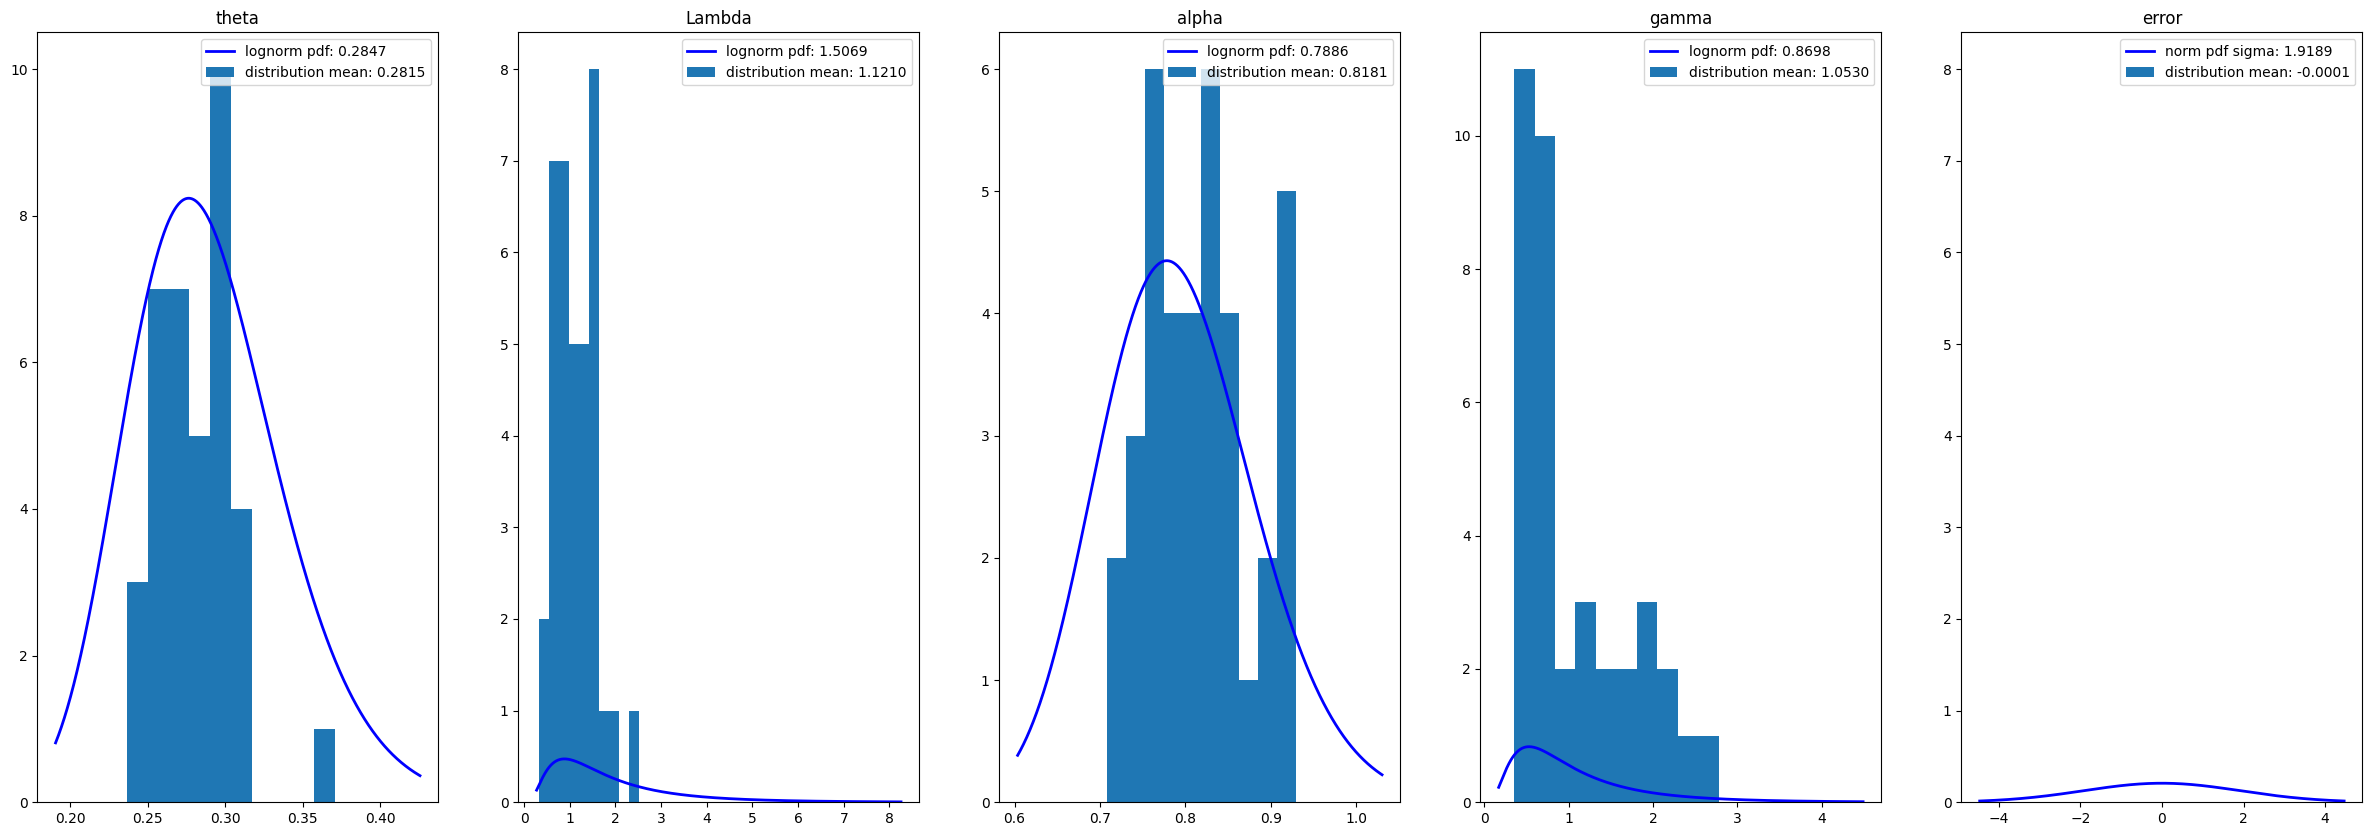

In [246]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(30,10))
for param,axis in zip(['theta', 'Lambda', 'alpha', 'gamma', 'error'],[ax1, ax2, ax3, ax4, ax5]):
    if param=='error':
        scale = distro_estimates['sigma'][param]
        frozen_norm = norm(0, scale)
        x = np.linspace(norm.ppf(.01, 0, scale),norm.ppf(.99, 0, scale), 1000)
        axis.plot(x, frozen_norm.pdf(x), 'b-', lw=2, alpha=1, label=f'norm pdf sigma: {scale:.4f}')
        axis.hist(estimation_results[param+'_single'] , alpha=1, label=f'distribution mean: {estimation_results[param+"_single"].mean():.4f}')
    else:
        s = distro_estimates['sigma'][param]
        scale = np.exp(distro_estimates['mu'][param])
        frozen_lognorm = lognorm(s, 0, scale)
        x = np.linspace(lognorm.ppf(.01, s, 0, scale),lognorm.ppf(.99, s, 0, scale), 1000)
        axis.plot(x, frozen_lognorm.pdf(x), 'b-', lw=2, alpha=1, label=f'lognorm pdf: {scale:.4f}')
        axis.hist(estimation_results[param+'_single'] , alpha=1, label=f'distribution mean: {estimation_results[param+"_single"].mean():.4f}')
    axis.legend()
    axis.set_title(param)

plt.show()

## calculate the number of deviations

In [159]:
# Calculating the probability to invest.
def calc_prob_invest(utility,tau):
    return (1)/(1+np.exp(-tau*utility))

# classify whether somebody invests or not.
def likelihood(gain, loss, prob_win, prob_loss, theta, Lambda, tau, alpha, beta, gamma=1, prob_ambi=None):
    ''' Function to determine if someone would invest in the gamble given theta, gamma, lambda, and tau.'''
    utility = calc_pt_utility(gain, loss, prob_win, prob_loss, theta, Lambda, alpha, beta, gamma=gamma, prob_ambi=prob_ambi)
    probability = calc_prob_invest(utility,tau)
    return probability

def compare_est_data(decisions_df, theta, Lambda, tau, alpha, beta, gamma=1, factor=1/100):
    ''' This is a function that quickly estimates the predicted investment decision based on the estimated parameters.
        Then compares it with the actual decisions. When is the first time that the estimates recreates the data perfectly.
    '''
    df = decisions_df.copy(True)
    df['predicted_invest'] = df.apply(lambda x: int(likelihood(x['gain']*factor, x['loss']*factor, x['prob_win'], x['prob_loss'],
                                          theta, Lambda, tau, alpha, beta, gamma)>=0.5), axis=1)
    df['diff'] = abs(df['predicted_invest'] - df['invest'])
    num_deviations = df['diff'].sum()
    return num_deviations

In [249]:
# collect all the thetas
for set,label in zip([results_decision_50],['_single']): #zip([results_decision_50, results_decision_25, results_decision],['_single', '_group', '_all'])
    for sub in results_decision.keys():
        for idx,param in enumerate(['theta', 'Lambda', 'alpha', 'gamma']):
            estimation_results.loc[sub,'num_deviations'+label] =  compare_est_data(
                            set[sub], estimation_results.loc[sub,'theta'+label],estimation_results.loc[sub,'Lambda'+label],
                            .28, estimation_results.loc[sub,'alpha'+label], .88, estimation_results.loc[sub,'gamma'+label], factor=1/100)

In [250]:
# estimation_results.to_csv('estimation_results.csv')
print(1-estimation_results['num_deviations_single'].sum()/(37*50))
estimation_results

0.772972972972973


,theta_single,Lambda_single,alpha_single,gamma_single,error_single,num_deviations_single
11112,0.267500,1.436237,0.832141,0.627117,0.000312,10.0
111,0.301000,1.772855,0.911911,0.777050,0.000154,9.0
14,0.303125,0.859811,0.715736,0.622095,0.005721,17.0
18670,0.293571,0.869305,0.772420,0.508583,0.003039,20.0
1970,0.290833,1.167798,0.899318,0.446746,0.003278,11.0
2301,0.291250,1.093369,0.800642,2.779950,-0.007072,8.0
24574,0.277222,0.764632,0.808730,0.604874,0.001655,14.0
24614,0.246875,1.536402,0.774022,1.371067,-0.002222,4.0
24683,0.236429,0.826964,0.780960,1.523437,-0.000248,8.0
24696,0.259286,0.769207,0.749997,1.140907,-0.003230,15.0


In [251]:
import scipy.io

In [252]:
results_micah = scipy.io.loadmat('T1_both_1000_tau_028.mat')


In [303]:
results_micah['stats'][0][0][1][0][0][4][0][0]

0.8785495259999996

In [318]:
estimation_results.index

Index(['11112', '111', '14', '18670', '1970', '2301', '24574', '24614',
       '24683', '24696', '24711', '24758', '33333', '36166', '44', '48002',
       '502', '51312', '53062', '56368', '56602', '566974', '57205', '57651',
       '57675', '57938', '58027', '58050', '58378', '58424', '58440', '58470',
       '58471', '58557', '58649', '777', '9031985'],
      dtype='object')

In [343]:
bayesian = pd.DataFrame()
for idx,i in enumerate(results_micah['subs2'][0]):
    bayesian.loc[str(i),'theta'] = results_micah['stats'][0][0][1][0][0][5][0][idx]
    bayesian.loc[str(i),'Lambda'] = results_micah['stats'][0][0][1][0][0][6][0][idx]
    bayesian.loc[str(i),'alpha'] = results_micah['stats'][0][0][1][0][0][4][0][idx]
    bayesian.loc[str(i),'gamma'] = results_micah['stats'][0][0][1][0][0][7][0][idx]


# 111	0.342257	1.688273	0.878550	0.804893
# 11112	0.296501	1.625926	0.847715	0.606078
bayesian = bayesian.reindex(estimation_results.index)
# bayesian


In [344]:
for sub in results_decision.keys():
        for idx,param in enumerate(['theta', 'Lambda', 'alpha', 'gamma']):
            bayesian.loc[sub,'num_deviations'] =  compare_est_data(
                            results_decision_50[sub], bayesian.loc[sub,'theta'],bayesian.loc[sub,'Lambda'],
                            .28, bayesian.loc[sub,'alpha'], .88, bayesian.loc[sub,'gamma'], factor=1/100)
print(1-bayesian['num_deviations'].sum()/(37*50))
bayesian

0.772972972972973


,theta,Lambda,alpha,gamma,num_deviations
11112,0.296501,1.625926,0.847715,0.606078,11.0
111,0.342257,1.688273,0.878550,0.804893,9.0
14,0.342285,1.542685,0.818112,0.343028,17.0
18670,0.343570,1.372266,0.852889,0.350437,16.0
1970,0.348848,1.334373,0.911709,0.431039,10.0
2301,0.317514,1.570494,0.853974,2.616106,8.0
24574,0.315241,1.138920,0.876743,0.481056,16.0
24614,0.246284,1.798647,0.799594,1.730439,5.0
24683,0.263804,1.314487,0.851222,3.515933,13.0
24696,0.290546,1.354576,0.822002,4.533916,14.0


In [354]:
estimation_diff = pd.concat([estimation_results,bayesian], axis=1)
estimation_diff['mix'] = estimation_diff.apply(lambda x: min(x['num_deviations'],x['num_deviations_single']), axis=1)

In [356]:
print(f"Bayesian estimation predicitons: {1-estimation_diff['num_deviations'].sum()/(37*50):.6f},  MSL estimation predicitons: {1-estimation_diff['num_deviations_single'].sum()/(37*50):.6f}, Mix predicitons: {1-estimation_diff['mix'].sum()/(37*50):.6f}")
print(f"Bayesian estimation predicitons: {estimation_diff['num_deviations'].sum()}, MSL estimation predicitons: {estimation_diff['num_deviations_single'].sum()}, , Mix predicitons: {estimation_diff['mix'].sum()}")


estimation_diff
estimation_diff[['theta_single', 'theta', 'Lambda_single', 'Lambda', 'alpha_single', 'alpha', 'gamma_single', 'gamma', 'num_deviations_single', 'num_deviations', 'mix']]

Bayesian estimation predicitons: 0.772973,  MSL estimation predicitons: 0.772973, Mix predicitons: 0.789189
Bayesian estimation predicitons: 420.0, MSL estimation predicitons: 420.0, , Mix predicitons: 390.0


,theta_single,theta,Lambda_single,Lambda,alpha_single,alpha,gamma_single,gamma,num_deviations_single,num_deviations,mix
11112,0.267500,0.296501,1.436237,1.625926,0.832141,0.847715,0.627117,0.606078,10.0,11.0,10.0
111,0.301000,0.342257,1.772855,1.688273,0.911911,0.878550,0.777050,0.804893,9.0,9.0,9.0
14,0.303125,0.342285,0.859811,1.542685,0.715736,0.818112,0.622095,0.343028,17.0,17.0,17.0
18670,0.293571,0.343570,0.869305,1.372266,0.772420,0.852889,0.508583,0.350437,20.0,16.0,16.0
1970,0.290833,0.348848,1.167798,1.334373,0.899318,0.911709,0.446746,0.431039,11.0,10.0,10.0
2301,0.291250,0.317514,1.093369,1.570494,0.800642,0.853974,2.779950,2.616106,8.0,8.0,8.0
24574,0.277222,0.315241,0.764632,1.138920,0.808730,0.876743,0.604874,0.481056,14.0,16.0,14.0
24614,0.246875,0.246284,1.536402,1.798647,0.774022,0.799594,1.371067,1.730439,4.0,5.0,4.0
24683,0.236429,0.263804,0.826964,1.314487,0.780960,0.851222,1.523437,3.515933,8.0,13.0,8.0
24696,0.259286,0.290546,0.769207,1.354576,0.749997,0.822002,1.140907,4.533916,15.0,14.0,14.0


In [1]:

import aesara.tensor as at



In [357]:
estimation_diff.corr()

,theta_single,Lambda_single,alpha_single,gamma_single,error_single,num_deviations_single,theta,Lambda,alpha,gamma,num_deviations,mix
theta_single,1.000000,-0.093715,0.043985,0.215036,-0.233921,0.274592,0.812250,-0.019254,0.218506,0.007210,0.029193,0.180748
Lambda_single,-0.093715,1.000000,0.464136,-0.493154,0.245458,-0.522654,-0.374530,0.856262,-0.279536,-0.591907,-0.669062,-0.549648
alpha_single,0.043985,0.464136,1.000000,-0.405994,0.115927,-0.350417,0.039073,-0.000419,0.692770,-0.485667,-0.383421,-0.344658
gamma_single,0.215036,-0.493154,-0.405994,1.000000,-0.757412,-0.141927,0.182182,-0.272101,-0.028737,0.805612,-0.053531,-0.143741
error_single,-0.233921,0.245458,0.115927,-0.757412,1.000000,0.101902,-0.211892,0.162402,-0.095806,-0.553332,0.102780,0.119836
num_deviations_single,0.274592,-0.522654,-0.350417,-0.141927,0.101902,1.000000,0.487022,-0.370027,0.056955,0.020466,0.854676,0.960898
theta,0.812250,-0.374530,0.039073,0.182182,-0.211892,0.487022,1.000000,-0.356047,0.443393,0.096290,0.340724,0.441572
Lambda,-0.019254,0.856262,-0.000419,-0.272101,0.162402,-0.370027,-0.356047,1.000000,-0.659014,-0.365492,-0.526554,-0.402603
alpha,0.218506,-0.279536,0.692770,-0.028737,-0.095806,0.056955,0.443393,-0.659014,1.000000,-0.087451,0.095009,0.063032
gamma,0.007210,-0.591907,-0.485667,0.805612,-0.553332,0.020466,0.096290,-0.365492,-0.087451,1.000000,0.209987,0.049081
